In [7]:
import torch
import torch.nn as nn
from torchvision.transforms import Compose, ToTensor, Normalize, Resize, CenterCrop, RandomCrop
import torch.nn.functional as F
from sklearn.metrics import accuracy_score 
import matplotlib.pyplot as plt
import pickle
from torchvision.models import MobileNet_V2_Weights


import cv2
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torchvision.io import read_image
import os
import numpy as np
# !kaggle datasets download soumikrakshit/nyu-depth-v2
# !unzip nyu-depth-v2.zip

In [2]:
class DepthwiseUpSampleConvolution(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv_depth = nn.Conv2d(in_channels = in_channels, out_channels=in_channels, kernel_size=(5,5), padding=2, groups=in_channels)
        self.bn1 = nn.BatchNorm2d(num_features=in_channels) 
        self.relu6 = nn.ReLU6(inplace=True)
        self.conv_pointwise = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=(1, 1), padding=0)
        self.bn2 = nn.BatchNorm2d(num_features=out_channels)
        self.relu = nn.ReLU(inplace=True)
    
    def forward(self, x):
        x  = self.relu6(self.bn1(self.conv_depth(x)))
        x = self.relu(self.bn2(self.conv_pointwise(x)))
        return F.interpolate(x, scale_factor=2, mode='nearest')
        
class FastDepth(nn.Module):
    def __init__(self):
        super().__init__()
        self.mobile_v2_encoder = torch.hub.load('pytorch/vision:v0.10.0', 'mobilenet_v2', weights=MobileNet_V2_Weights.IMAGENET1K_V1)
        self.dec1 = DepthwiseUpSampleConvolution(320, 96)
        self.dec2 = DepthwiseUpSampleConvolution(96, 32)
        self.dec3 = DepthwiseUpSampleConvolution(32, 24)
        self.dec4 = DepthwiseUpSampleConvolution(24, 16)
        self.dec5 = DepthwiseUpSampleConvolution(16, 32)
        self.final_conv = nn.Conv2d(in_channels=32, out_channels=1, kernel_size=1, stride=1, padding=0)

    def forward(self, x):
        x = self.mobile_v2_encoder.features[0](x)
        x = self.mobile_v2_encoder.features[1](x)
        layer1 = x
        x = self.mobile_v2_encoder.features[2](x)
        x = self.mobile_v2_encoder.features[3](x)
        layer2 = x
        x = self.mobile_v2_encoder.features[4](x)
        x = self.mobile_v2_encoder.features[5](x)
        layer3 = x
        for i in range(6, 18):
            x = self.mobile_v2_encoder.features[i](x)
        x = self.dec1(x)
        x = self.dec2(x)
        x = x + layer3
        x = self.dec3(x)
        x = x + layer2
        x = self.dec4(x)
        x = x + layer1
        x = self.dec5(x)
        return self.final_conv(x)

In [3]:
import csv

TRAIN_DATA = "./nyu_data/data/nyu2_train.csv"
TEST_DATA = "./nyu_data/data/nyu2_test.csv"

class DepthImageDataset(Dataset):
    def __init__(self, csv_file_name, train=True, transform=None, label_transform=None):
        self.transform = transform
        self.label_transform = label_transform
        self.files_paths = []
        self.label_paths = []
        self.train = train
        with open(csv_file_name, mode ='r') as file:
            csvFile = csv.reader(file)
            for lines in csvFile:
                self.files_paths.append("./nyu_data/" + lines[0])
                self.label_paths.append("./nyu_data/" + lines[1])
    
    def __len__(self):
        return len(self.files_paths)
    
    def get_my_item(self, idx):
        return self.__getitem__(idx)

    def __getitem__(self, idx):
        img = cv2.imread(self.files_paths[idx], flags=cv2.IMREAD_COLOR)
        depth_img = cv2.imread(self.label_paths[idx], flags=cv2.IMREAD_UNCHANGED)
        # print(depth_img.dtype, depth_img.max(), depth_img.min())
        if (not self.train):
            depth_img = depth_img / depth_img.max()
        # print(depth_img.dtype, depth_img.max(), depth_img.min())
        img = img if (self.transform == None) else self.transform(img)
        depth_img = depth_img if (self.label_transform == None) else self.label_transform(depth_img)
        return img, depth_img

In [4]:
PATH_MODEL = "./trained_fast_depth.pth"

class EarlyStopping:
    def __init__(self, model : FastDepth, patience, path):
        self.path = path
        self.patience = patience
        self.model = model
        self.current_patience = patience
        self.current_loss = float('inf')

    def should_continue(self, loss):
        if (loss < self.current_loss):
            self.current_loss = loss
            self.current_patience = self.patience
            torch.save(self.model.state_dict(), PATH_MODEL)
        else:
            self.current_patience -= 1
            if (self.current_patience == 0): return False
        return True

    def load_model(self):
        model = FastDepth()
        model.load_state_dict(torch.load(PATH_MODEL))
        return model
    
def plot_losses(train_losses: list[float], validation_losses: list[float], label_x : str, label_y : str, title : str) -> None:
    """Plots training and validation losses over epochs."""
    plt.figure(figsize=(8, 6))
    plt.plot(train_losses, label=label_x, marker="o")
    plt.plot(validation_losses, label=label_y, marker="o")
    plt.xlabel(label_x)
    plt.ylabel(label_y)
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()
    

def compute_depth_accuracy_batch_photos(found_depth: torch.Tensor, depth: torch.Tensor, epsilon=1e-6):
    relative_error = torch.abs(found_depth - depth) / (depth + epsilon) 
    right_examples = relative_error < 0.25
    total_elements = right_examples.numel()  
    return torch.sum(right_examples).float() / total_elements


def train_depth(model, dataloader, optimizer, criterion):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.train()
    train_loss = 0
    train_accuracy = 0 
    for idx, (inputs, labels) in enumerate(dataloader):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        # loss = torch.sqrt(criterion(outputs, labels))
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        current_train_acc = compute_depth_accuracy_batch_photos(outputs, labels).item() 
        train_accuracy += current_train_acc
    return train_loss / len(dataloader), train_accuracy / len(dataloader) 

def test_depth(model, dataloader, criterion):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    with torch.no_grad():
        validation_loss = 0
        validation_accuracy = 0
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            output = model(inputs)
            current_loss = criterion(output, labels).item()
            # current_loss = torch.sqrt(criterion(output, labels)).item()
            current_acc = compute_depth_accuracy_batch_photos(output, labels).item()
            # print(current_loss, current_acc)
            validation_loss += current_loss
            validation_accuracy += current_acc
        return validation_loss / len(dataloader), validation_accuracy / len(dataloader)
    
def train_depth_model(model, data, criterion, optimizer, lr_scheduler, epochs, early_stopper : EarlyStopping):
    train_info = {
        "train_loss": [],
        "validation_loss" : [],
        "train_accuracy": [],
        "validation_accuracy" : []
    }
    max_acc = 0
    try:
        for i in range(epochs):
            train_loss, train_acc = train_depth(model, data["train"], optimizer, criterion)
        
            val_loss, val_acc = test_depth(model, data["validation"], criterion)
            if (val_acc > max_acc):
                max_acc = val_acc
                print("acuratete maxima la epoca", i)
            lr_scheduler.step(val_loss)
            # print(train_loss, train_acc, "epoch: ", i)
            print(val_loss, val_acc, "epoch: ", i)
            train_info["train_loss"].append(train_loss)
            train_info["validation_loss"].append(val_loss)
            train_info["train_accuracy"].append(train_acc)
            train_info["validation_accuracy"].append(val_acc)
            if not early_stopper.should_continue(val_loss): break
        plot_losses(train_info["train_loss"], train_info["validation_loss"], 
            "Epochs", "Loss", "Training and Validation Loss")
        plot_losses(train_info["train_accuracy"], train_info["validation_accuracy"], 
            "Epochs", "Accuracy", "Training and Validation Accuracy")
    except KeyboardInterrupt:
        plot_losses(train_info["train_loss"], train_info["validation_loss"], 
            "Epochs", "Loss", "Training and Validation Loss")
        plot_losses(train_info["train_accuracy"], train_info["validation_accuracy"], 
            "Epochs", "Accuracy", "Training and Validation Accuracy")
        return train_info
    return train_info


In [5]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [ ]:
def compute_loss_function(pred : torch.Tensor, label : torch.Tensor):
     mae_loss = torch.sum(torch.abs(label - pred)) / pred.numel()
     


cuda


Using cache found in /home/alf/.cache/torch/hub/pytorch_vision_v0.10.0


acuratete maxima la epoca 0
0.3312224483536841 0.1099468078573548 epoch:  0
acuratete maxima la epoca 1
0.28912498495270544 0.18548845310802117 epoch:  1
0.2944147047044114 0.17625883107236046 epoch:  2
0.2966693893107168 0.1731603188847841 epoch:  3
0.29897246759089224 0.16462955240199376 epoch:  4


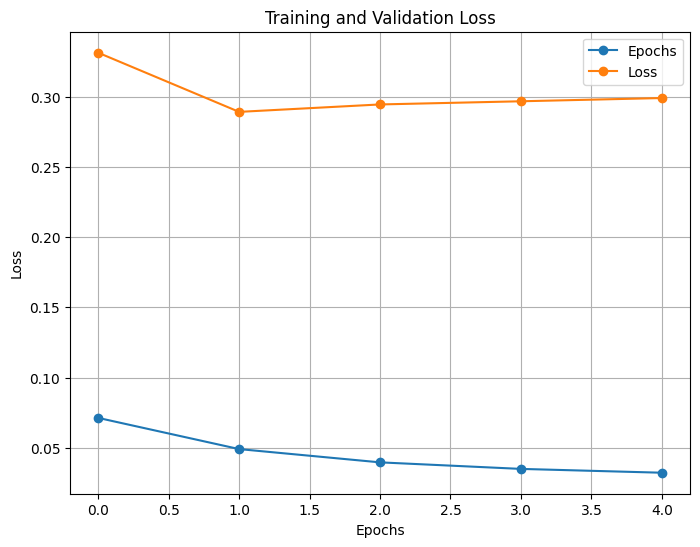

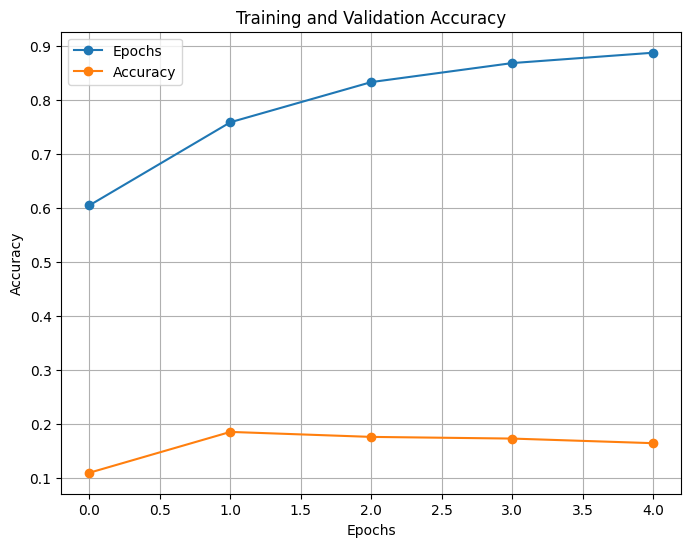

{'train_loss': [0.07135303669686739, 0.04915567091430979, 0.039710357040872404, 0.03505637264114363, 0.03233747216819955], 'validation_loss': [0.3312224483536841, 0.28912498495270544, 0.2944147047044114, 0.2966693893107168, 0.29897246759089224], 'train_accuracy': [0.6049169005486277, 0.7586837693686701, 0.8330189177456001, 0.8682189172114989, 0.8873887528298479], 'validation_accuracy': [0.1099468078573548, 0.18548845310802117, 0.17625883107236046, 0.1731603188847841, 0.16462955240199376]}


Using cache found in /home/alf/.cache/torch/hub/pytorch_vision_v0.10.0


0.18548845310802117


In [ ]:
SIZE=(232, 232)
parameters = {
    "batch_size" : 8,
    'epochs' : 10,
    'lr_optimizer': 1e-2,
    'gamma_lr': 0.3,
    'weight_decay_factor': 1e-4,
    'patience': 50,
    'early_stopper': 10,
    "momentum" : 0.9,
}

train_transforms = Compose([
    ToTensor(),  
    Resize(size=SIZE),
    CenterCrop(size=(224, 224)),
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    RandomCrop(padding=3, size=15)
    
])

test_transforms = Compose([
    ToTensor(),
    Resize(size=SIZE),
    CenterCrop(size=(224, 224)),
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    
])

label_transforms = Compose([
    ToTensor(),
    Resize(size=SIZE),
    CenterCrop(size=(224, 224)),
])

data = {
    "train": DataLoader(DepthImageDataset(TRAIN_DATA, transform=train_transforms, label_transform=label_transforms), batch_size=parameters["batch_size"], shuffle=True, num_workers=4),
    "validation": DataLoader(DepthImageDataset(TEST_DATA, train=False, transform=test_transforms, label_transform=label_transforms), batch_size=1, shuffle=True, num_workers=4)
}

model = FastDepth()
# print(len(data["train"]))
# print(len(data["validation"]))
# for i in range(0, 100):
#     # x, y = data["train"].dataset.__getitem__(i)
#     x, y = data["train"].dataset.__getitem__(i)
#     x = x.unsqueeze(dim=0)
#     y = y.unsqueeze(dim=0)
#     print(x.shape, x.type(), x.max(), x.min())
#     print(y.shape, y.type(), y.float().max(), y.float().min())
#     out = model(x)
#     print(out.shape, out.type(), out.max(), out.min())
#     print(compute_depth_accuracy_batch_photos(out, y))
#     print()
#     # print(out.max(), out.min())
#     # print(y.max(), y.min())
#     # print()
#     break

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
print(device)
early_stopper = EarlyStopping(model, parameters["early_stopper"], PATH_MODEL)
criterion = nn.L1Loss()
optimizer = torch.optim.SGD(model.parameters(), lr=parameters["lr_optimizer"], momentum=parameters["momentum"], weight_decay=parameters["weight_decay_factor"])
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=parameters['gamma_lr'], patience=parameters['patience'])
train_info = train_depth_model(model, data, criterion, optimizer, lr_scheduler, parameters['epochs'], early_stopper)
print(train_info)
new_model = FastDepth()
new_model.load_state_dict(torch.load(PATH_MODEL, weights_only=True))
new_model.to(device)
_, accuracy  = test_depth(new_model, data["validation"], criterion)
print(accuracy)

In [ ]:
# model = FastDepth()
# model.load_state_dict(torch.load("./depth_model.pth", weights_only=True))
model.to("cpu")

def compute_depth_accuracy_batch_photos(found_depth : torch.tensor, depth : torch.tensor):
    right_examples = torch.div(torch.abs(found_depth - depth), depth) < 0.25
    size = right_examples.shape[0] * right_examples.shape[1] * right_examples.shape[2] * right_examples.shape[3]
    return torch.sum(right_examples) / size

for iddx, (images, labels) in enumerate(data["validation"]):
    out = model(images)
    print(torch.max(labels), torch.min(labels))
    print(torch.max(out), torch.min(out))
    print(compute_depth_accuracy_batch_photos(out, labels))
    initial_image = images[0].permute((1, 2, 0))
    labels_image = labels[0].permute((1, 2, 0))
    output_image = out[0].permute((1, 2, 0))
    # initial_image = (initial_image.detach().cpu().numpy().squeeze())
    labels_image = (labels_image.detach().cpu().numpy().squeeze())
    output_image = (output_image.detach().cpu().numpy().squeeze())
    plt.figure(figsize=(24, 24))
    plt.subplot(1, 3, 1) 
    plt.imshow(initial_image)
    plt.axis('off')
    plt.subplot(1, 3, 2)
    plt.imshow(output_image)
    plt.axis('off')
    plt.subplot(1, 3, 3)
    plt.imshow(labels_image)
    plt.axis('off')
    break

In [ ]:
img = cv2.imread("./inside_home.jpg")
img = cv2.resize(img, dsize=(512, 512))
img = test_transforms(img)
for_plt = img.permute((1, 2, 0))
for_plt = for_plt.detach().cpu().numpy().squeeze()
for_model = img.unsqueeze(dim=0)
depth_this_image = model(for_model)
print(torch.max(depth_this_image), torch.min(depth_this_image))
depth_this_image = depth_this_image.detach().cpu().numpy().squeeze()
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1) 
plt.imshow(for_plt)
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(depth_this_image)
print(depth_this_image)

In [9]:
torch_input = torch.rand(size=(1, 3, 224, 224))
torch.onnx.export(model, torch_input, "fast_depth.onnx", opset_version=11)

In [ ]:
import onnxruntime
session = onnxruntime.InferenceSession("./fast_depth.onnx")
print("ONNX model loaded successfully in ONNX Runtime")